In [1]:
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# local
from utils import *
sys.path.append("../imaging-utils")
from image_arrays import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

In [3]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_06_16_processed_4x4")
stim_labels = ["moving_spot"]

In [4]:
vel_data = {
    stim: {
        depth: {
            int(vel): np.stack(
                [
                    io.imread(os.path.join(data_path, stim, depth, vel, f))
                    for f in os.listdir(os.path.join(data_path, stim, depth, vel))
                    if (f.endswith(".tiff") or f.endswith(".tif"))
                ],
                axis=0
            )
            for vel in os.listdir(os.path.join(data_path, stim, depth))
            if (os.path.isdir(os.path.join(data_path, stim, depth, vel)) and vel.isnumeric())        
        }
        for depth in ["DD", "PD"]
    } for stim in stim_labels
}

vel_df = {
    stim: {
        d: {
            v: ((trials - np.mean(trials[:, 50:150], axis=1, keepdims=True)) 
                / (np.mean(trials[:, 50:150], axis=1, keepdims=True) + 0.00001))
            for v, trials in vels.items()
        }
        for d, vels in depths.items()
    } for stim, depths in vel_data.items()
}

n_trials, n_frames, y_sz, x_sz = vel_data[stim_labels[0]]["DD"][300].shape
dt = 1 / 565
recs_xaxis = np.arange(n_frames) * dt
velocities = np.array(list(sorted(vel_data[stim_labels[0]]["DD"].keys())))
print("velocity stack shape:", vel_data[stim_labels[0]]["DD"][300].shape)

velocity stack shape: (2, 450, 64, 64)


### Dynamic ROI plot of a scan (of particular `depth`) during stimulation by spot moving at `vel` 

<IPython.core.display.Javascript object>


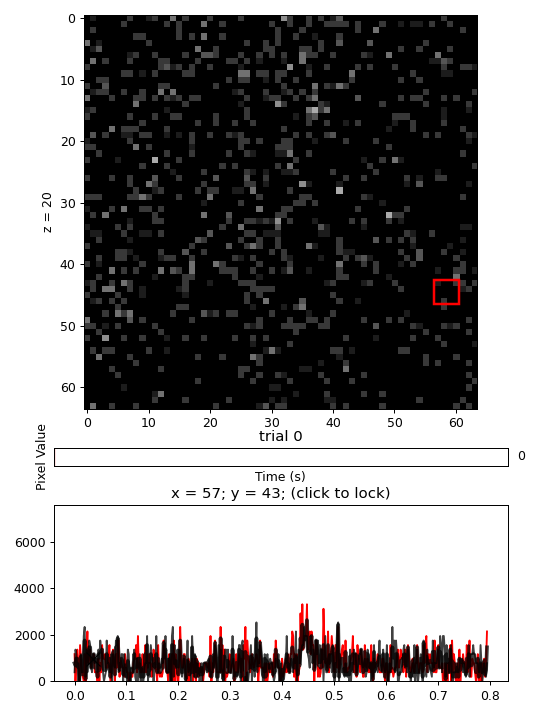

In [14]:
vel = 300
stim = "moving_spot"
depth = "PD"

stack_plot = StackExplorer(
    vel_data[stim][depth][vel],
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=(4, 4),
    vmin=0,
    figsize=(6, 8)
)
stack_plot.ax[1].set_xlabel("Time (s)")
stack_plot.ax[1].set_ylabel("Pixel Value")
stack_plot.fig.show()

### Grid ROI placement
Take `grid_w` by `grid_h` beams from the scan field

In [21]:
grid_w = 4
grid_h = 4

def aligned_avg(avg_recs, bsln_start=50, bsln_end=150, step=1):
    rise_idxs = np.array([
            find_rise_bsln(r, bsln_start=bsln_start, bsln_end=bsln_end, step=step)
            for r in avg_recs
        ])
    shifts = rise_idxs - np.min(rise_idxs)
    trim = np.max(shifts)
    aligned = np.mean(
        [r[s:(-trim + s) if s != trim else None] for r, s in zip(avg_recs, shifts)],
        axis=0
    )
    return aligned

min_qi = .55
grid_recs, avg_grid_recs, aligned_grid_avg, grid_locs, all_qis, accepted_qis = [
    {} for _ in range(6)
]
for depth, vels in vel_data[stim].items():
    grid_recs[depth], avg_grid_recs[depth], grid_locs[depth] = {}, {}, {}
    aligned_grid_avg[depth], all_qis[depth], accepted_qis[depth] = {}, {}, {}
    for v, stack in vels.items():
        recs, locs, acc_qis, qis = [], [], [], []
        for y0 in range(0, y_sz, grid_h):
            for x0 in range(0, x_sz, grid_w):
                beams = np.mean(stack[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
                qi = quality_index(beams[:, 150:])
                qis.append(qi)
                if qi > min_qi:
                    acc_qis.append(qi)
                    recs.append(beams)
                    locs.append([x0, y0])        
        grid_recs[depth][v] = np.stack(recs, axis=1)
        avg_grid_recs[depth][v] = np.mean(grid_recs[depth][v], axis=0)
        grid_locs[depth][v] = np.stack(locs, axis=0)
        aligned_grid_avg[depth][v] = aligned_avg(avg_grid_recs[depth][v])
        accepted_qis[depth][v] = np.array(acc_qis)
        all_qis[depth][v] = np.array(qis)

# print("number of grid ROIs accepted:", grid_recs.shape[1])

<IPython.core.display.Javascript object>


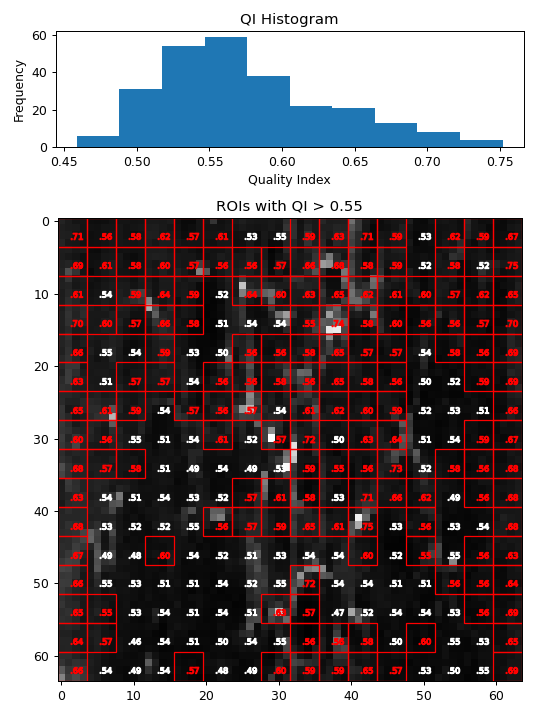

In [22]:
depth = "PD"
vel = 300

mean_stack_proj = np.mean(vel_data[stim][depth][vel], axis=(0,1))
    
half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(
    2, 
    gridspec_kw={"height_ratios": [.2, .8]}, 
    figsize=(6, 8)
)

grid_ax[0].hist(all_qis[depth][vel])
grid_ax[0].set_title("QI Histogram")
grid_ax[0].set_xlabel("Quality Index")
grid_ax[0].set_ylabel("Frequency")

grid_ax[1].imshow(mean_stack_proj, cmap="gray")
grid_ax[1].set_title("ROIs with QI > %.2f" % min_qi)

for (x, y) in grid_locs[depth][vel]:
    grid_ax[1].add_patch(
        Rectangle(
            (x - .5, y - .5),  # grid offset
            grid_w, 
            grid_h, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

i = 0
for y0 in range(0, y_sz, grid_h):
    for x0 in range(0, x_sz, grid_w):
        grid_ax[1].scatter(
            x0 + half_w,
            y0 + half_h, 
            marker="$%s$" % ("%.2f" % all_qis[depth][vel][i]).lstrip("0"), 
            s=100,
            c="red" if all_qis[depth][vel][i] > min_qi else "1",
        )
        i += 1
        
grid_fig.tight_layout()

### Use PeakExplorer to browse through ROIs (scroll wheel) of from the average scans taken from `depth` during `vel` stimulation  

<IPython.core.display.Javascript object>


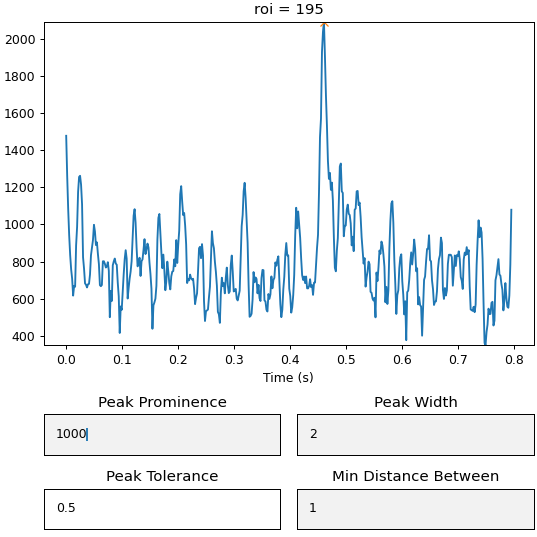

In [8]:
depth = "PD"
vel = 300


filtered = np.stack(
    [savgol_filter(roi, 11, 3) for roi in avg_grid_recs[depth][vel]], 
    axis=0
)

peak_explorer = PeakExplorer(
    recs_xaxis, 
#     grid_recs[depth][vel][0],
#     avg_grid_recs[depth][vel],
    filtered,
    prominence=8,
    width=2,
    tolerance=.5,
    distance=1
)

### Comparison between ROIs (or aligned averages) of DD and PD depths for each velocity 

<IPython.core.display.Javascript object>


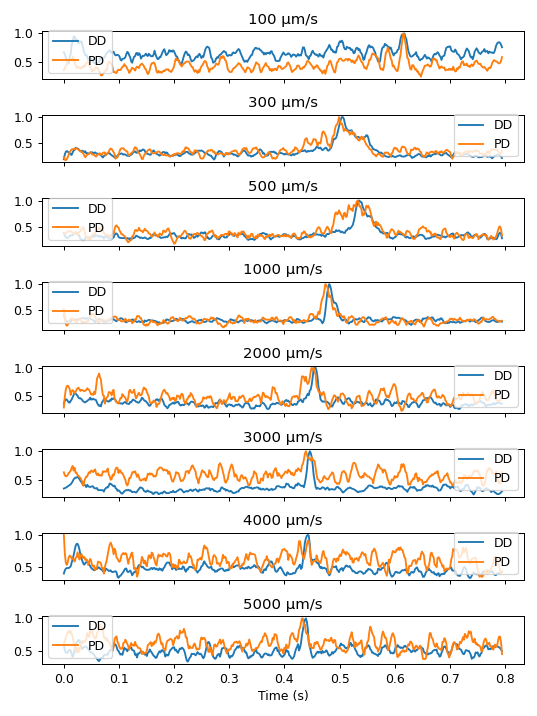

In [10]:
grid_idxs = {"DD": 5, "PD": 5}
# grid_idxs = {"DD": 0, "PD": 0}
use_aligned = False

norm = True
depth_comp_fig, depth_comp_ax = plt.subplots(len(velocities), sharex=True, figsize=(6, 8))
for ax, vel in zip(depth_comp_ax, velocities):
#     if vel == 3000:
#         continue
    for depth in vel_data[stim].keys():
        if use_aligned:
            y = savgol_filter(aligned_grid_avg[depth][vel], 21, 3)
        else:
            y = savgol_filter(avg_grid_recs[depth][vel][grid_idxs[depth]], 11, 3)
#         y = avg_grid_recs[depth][vel][3]
#         y = savgol_filter(grid_recs[depth][vel][1, 2], 21, 3)
        x = np.arange(len(y)) * dt
        if norm:
            y /= y.max()
        ax.plot(x, y, label=depth)
        ax.set_title("%i μm/s" % vel)
        ax.legend()
#         ax.set_xlim(4, 5.7)

depth_comp_ax[-1].set_xlabel("Time (s)")
depth_comp_fig.tight_layout()